# Day of *[Water]* Data 2023

*Resources for participants in the [University of Minnesota Day of Data 2023](https://sites.google.com/umn.edu/umn-day-of-data/home?pli=1). Created by Daniel E. Sandborn, [Large Lakes Observatory](https://scse.d.umn.edu/large-lakes-observatory), University of Minnesota Duluth.  This material is covered by a GNU General Public License v3.*

> This material accompanies a talk delivered by the author at the UMN Day of Data event in January 2023.  It relies on Python to analyze data and create visualizations. To run the code in this document, you have at least two options: 
> 1. Cut-and-paste code snippets into a Python terminal of choice.  This may take the form of Spyder, Jupyter, IDLE, etc. 
> 2. Download and run the Jupyter Notebook available on Github [here](https://github.com/d-sandborn/DayOfWaterData2023#introduction-to-lake-and-ocean-observation-systems).

> Note that you'll need the accessory datafiles, which are available on Github [here](https://github.com/d-sandborn/DayOfWaterData2023#introduction-to-lake-and-ocean-observation-systems).

> If you aren't familiar with Python code, don't worry! This material is designed to be accessible regardless of coding experience.

In [2]:
# We begin by importing packages we'll need.
# You may need to download some packages if they aren't already available.
# Check the package websites for details.

import pandas as pd  # for matrix manipulation
import numpy as np  # general-use numerical functions
from erddapy import ERDDAP  # for accessing buoy data directly
import geopandas as gp  # mapping toolkit
from PIL import Image, ImageDraw  # image I/O functions
import matplotlib.pyplot as plt  # highly-flexible graphing package
from scipy import optimize  # curve-fitting toolkit

## Introduction to Lake and Ocean Observation Systems

Observers of lakes and oceans have a choice of many instruments and strategies, including moored instruments (buoys), research cruises, drifting buoys, autonomous profilers, and more.  Ocean and lake processes exist on various scales, with temporal variability between seconds and millennia, and spatial variability between millimeters and thousands of kilometers.  

To observe a process, you have to match your observation strategy to phenomena of interest. It's no use trying to study global thermohaline ocean circulation with a single buoy, nor in studying climate change with short-term observations. 

![Observation Variability Plot, Bushinsky et al. 2019](.\Images\ObsVarPlot.JPG "Observation Variability Plot, Bushinsky et al. 2019")

Plotting spatial variability on one axis and temporal variability on the other illustrates the overlap among various ocean phenomena and observation techniques (Bushinsky et al. 2019[^1]).  These overlaps are the zones we target with our instruments.

## Climate, Weather, and the Laurentian Great Lakes

The Laurentian Great Lakes contain about 21% of the Earth's surface freshwater[^2]. They influence regional climate and weather over a large portion of North America, as evidenced by cooler temperatures near the lakes in summer and lake effect snowfall in early winter.  Recent research has highlighted the many ways in which we are modifying the physical, chemical, and biological states of the Great Lakes.  

**Our lakes are getting warmer** (Austin and Coleman, 2008[^3])

![Timeseries of Lake Superior mean summer surface water temperatures, from Austin and Coleman 2008.](./Images/SupTemp.JPG "Timeseries of Lake Superior mean summer surface water temperatures, from Austin and Coleman 2008.")

**Our lakes are getting saltier** (Chapra et al. 2012[^4])

![Laurentian Great Lakes chloride and sodium ion concentrations, from Chapra et al. 2012.](./Images/ChapraNaCl.JPG "Laurentian Great Lakes chloride and sodium ion concentrations, from Chapra et al. 2012.")

**Our lakes are experiencing unprecedented harmful algal blooms** (Sterner et al. 2020[^5])

![Harmful algal bloom sighting and sampling, from Sterner et al. 2020.](./Images/Sterner2020.JPG "Harmful algal bloom sighting and sampling, from Sterner et al. 2020.")

**Our lakes (especially poorly-buffered lakes like Superior) may be acidifying** (Sandborn and Minor, 2022[^6]; after Phillips et al. 2015[^7])

![Forecasted Carbon Dioxide-driven acidification of Lake Superior, by Sandborn and Minor 2002 after Phillips et al. 2015.](./Images/SMafterPhillips.jpg "Forecasted Carbon Dioxide-driven acidification of Lake Superior, by Sandborn and Minor 2002 after Phillips et al. 2015.")

This research, as well as management and policy decisions that can mitigate harmful changes, rely upon observation strategies spanning minutes to centuries, and creeks to continents. Below I briefly talk about three obsevational strategies used in the Laurentian Great Lakes to generate data that improves our understanding of these valuable and unique large lake ecosystems.

## Buoys

Moored instruments (aka buoys) are among the water scientists' most valuable tools for extended observational campaigns, recording data about physical, as well as some chemical and biological parameters.  There were more than 100 instrument moorings deployed on the Great Lakes during the 2022 field season by organizations including universities, federal, state, and provincial agencies, and other local stakeholders. Data from many of these moorings is collected by the [Great Lakes Observing System](https://seagull.glos.org/landing) (GLOS), which is a member of the [Integrated Ocean Observing System](https://ioos.noaa.gov/regions/) (IOOS).

Moorings provide a treasure-trove of data, informing researchers and managers on very small spatial scales, yet with high-frequency and extended-duration data streams.  Networks of buoys can extend the scope of moored observations, but it's impractical to cover Lake Superior (let alone the global ocean) with enough moorings to observe large-scale trends, especially in spatially-variable systems like large lakes and coasts.  

Here I'll demonstrate the use of a data access protocol (DAP) to obtain data on wave height and temperature from a mooring maintained by the Large Lakes Observatory at the University of Minnesota Duluth.  The mooring is just north of Duluth, near McQuade Harbor.  Wave heights and water temperature are two physical variables particularly suited for moored observations.  They help inform our understanding of lake productivity energy and mass exchange, and -- this one is critical -- the optimal conditions for surfing on the North Shore.

Data access protocols such as [ERDDAP](https://coastwatch.pfeg.noaa.gov/erddap/index.html) (maintained by IOOS in partnership with NOAA) allow us to easily and quickly obtain high-resolution, real-time information from remote locations.  From the data scientist's perspective, however, things aren't so simple as asking a server for information and plotting it up.  These data are subject to instrument and transmission errors, downtime, and weather/climate constraints.  

C:\Users\Daniel Sandborn\AppData\Local\Temp\ipykernel_19876\3123346728.py:32: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.time = df.loc[:, "time (UTC)"]


Text(1, 0, 'Plot: Daniel E. Sandborn 2023')

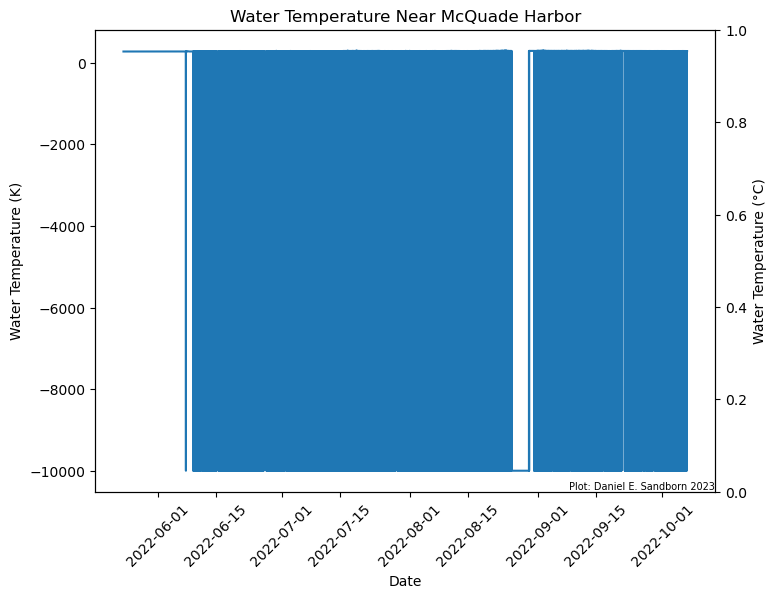

In [3]:
e = ERDDAP(
    server="https://seagull-erddap.glos.org/erddap",
    protocol="tabledap",
    response="csv",
)

e.dataset_id = "obs_45"

e.variables = [
    "time",
    "wtmp1",
    "wtmp3",
    "wtmp8",
    "wtmp13",
    "wtmp18",
    "wtmp23",
    "wtmp28",
    "wtmp33",
    "wtmp38",
    "wtmp43"
]

e.constraints = {
    "time>=": "2022-05-23T00:00:00Z",
    "time<=": "2022-10-7T00:00:00Z",
}

df = e.to_pandas(
    #index_col="time (UTC)",
    parse_dates=["time (UTC)"],
).dropna()
df.time = df.loc[:, "time (UTC)"]

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(df.time, df.loc[:, "wtmp1 (K)"])
ax2 = ax.twinx()
mn, mx = ax.get_ylim()
#ax2.set_ylim(mn-273.15, mx-273.15)
ax2.set_ylabel('Water Temperature (°C)')
ax.set_xlabel('Date')
ax.set_ylabel('Water Temperature (K)')
ax.set_title('Water Temperature Near McQuade Harbor')
ax.tick_params(axis='x', labelrotation=45)
ax.annotate('Plot: Daniel E. Sandborn 2023', xy=(1, 0),xycoords='axes fraction', fontsize=7, horizontalalignment='right', verticalalignment='bottom')

After downloading data from the Great Lakes Observing System via ERDDAP for summer 2022 (the mooring was retrieved in October before wave and ice action could destroy it), an anomaly is evident in the temperature timeseries: many readings of -9999 K. Clearly this is an instrumental error, likely denoting a thermistor voltage out-of-range.  These are easily removed.

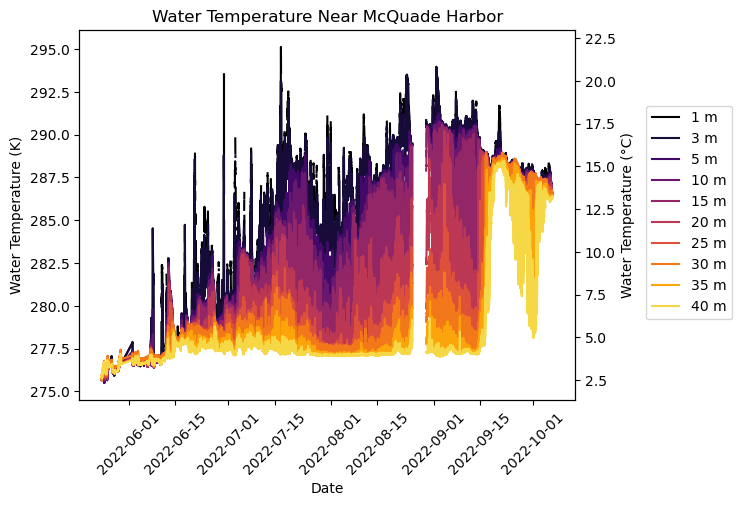

In [4]:
datacolumns = ['wtmp1 (K)', 'wtmp3 (K)', 'wtmp8 (K)', 'wtmp13 (K)',
               'wtmp18 (K)', 'wtmp23 (K)', 'wtmp28 (K)', 'wtmp33 (K)', 'wtmp38 (K)',
               'wtmp43 (K)'] #create a list of our variables for use in the for loop below

for i in df.index: #for each row
    for j in datacolumns: #for each column in each row
        if df.loc[i, j] < 0: #if the temperature value is less than 0:
            df.loc[i, j] = np.nan #nix it and replace with a "not a number" value

colors = iter([plt.cm.inferno(i) for i in np.linspace(0, 1, 11)]) #prepare an iterator of colors to apply to each line

fig, ax = plt.subplots() #initialize matplotlib plot
ax.plot(df.time, df.loc[:, "wtmp1 (K)"], c=next(colors), label='1 m') #plot line for each depth category, with a label corresponding to the depth
ax.plot(df.time, df.loc[:, "wtmp3 (K)"], c=next(colors), label='3 m')
ax.plot(df.time, df.loc[:, "wtmp8 (K)"], c=next(colors), label='5 m')
ax.plot(df.time, df.loc[:, "wtmp13 (K)"], c=next(colors), label='10 m')
ax.plot(df.time, df.loc[:, "wtmp18 (K)"], c=next(colors), label='15 m')
ax.plot(df.time, df.loc[:, "wtmp23 (K)"], c=next(colors), label='20 m')
ax.plot(df.time, df.loc[:, "wtmp28 (K)"], c=next(colors), label='25 m')
ax.plot(df.time, df.loc[:, "wtmp33 (K)"], c=next(colors), label='30 m')
ax.plot(df.time, df.loc[:, "wtmp38 (K)"], c=next(colors), label='35 m')
ax.plot(df.time, df.loc[:, "wtmp43 (K)"], c=next(colors), label='40 m')
ax2 = ax.twinx() #add the celcius scale at right
mn, mx = ax.get_ylim()
ax2.set_ylim(mn-273.15, mx-273.15)
ax2.set_ylabel('Water Temperature (°C)')
ax.set_xlabel('Date')
ax.set_ylabel('Water Temperature (K)')
ax.set_title('Water Temperature Near McQuade Harbor')
ax.tick_params(axis='x', labelrotation=45)
fig.legend(bbox_to_anchor=(1, 0.5), loc="center left")

The timeseries with errors removed displays the expected seasonal trend: surface temperatures increase through the summer before decreasing in fall.  Spring destratification is also evident near June: at this point the entire water column is the same temperature (and therefore density), such that even a light breeze can circulate water throughout the lake.  Later on, surface waters are significantly warmer (and therefore less dense) which limits exchange of water, matter, and energy betwen the surface and depths.  

Gaps are also evident in the timeseries, sometimes lasting days.  Transmission (via a cellular network in this case) can be interrupted or disabled by any number of hardware or software issues.  One last constraint of moored observations has already been hinted at: moorings in the Great Lakes and high latitude oceans are typically retrieved before winter arrives, with its high seas and crushing ice floes.  Gaps in observations can be significant obstacles to understanding lake and ocean biogeochemistry; winter limnology is an active field of research.[^8]

Now we can talk about surfing.  Strong winds from the northeast are common on Lake Superior in the Fall thru Spring.  Over exceedingly long stretches of open water (e.g. over the ocean, or the line from the North Shore to the Slate Islands) the *fetch* of this wind can create surfable waves.  Surfers know to check a series of moorings stretching from Isle Royale down to Duluth to predict wave intensity days to hours in advance. Can we visualize the connection between wave height and its hypothesized driver variables?

Let's start with a simple timeseries of wave height, measured at the same mooring as above.

C:\Users\Daniel Sandborn\AppData\Local\Temp\ipykernel_19876\3436839883.py:22: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.time = df.loc[:, "time (UTC)"]


Text(1, 0, 'Plot: Daniel E. Sandborn 2023')

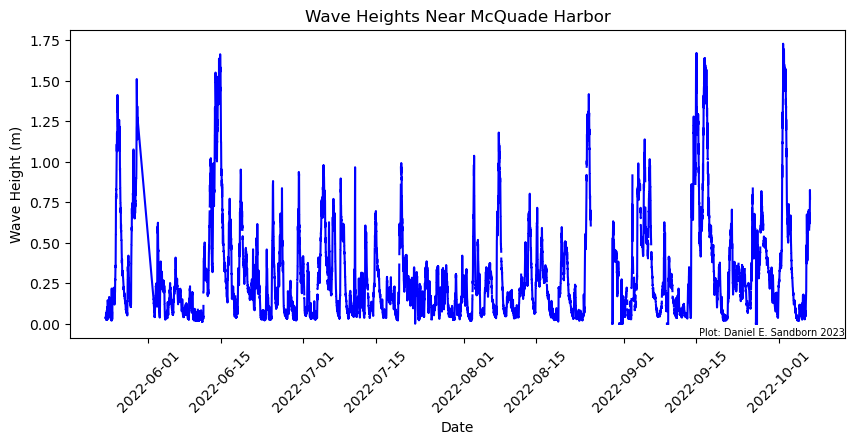

In [5]:
e = ERDDAP(
    server="https://seagull-erddap.glos.org/erddap",
    protocol="tabledap",
    response="csv",
)

e.dataset_id = "obs_45"

e.variables = [
    "time",
    "wvhgt",
    "wspd1",
    "wdir1"
]

e.constraints = {
    "time>=": "2022-05-23T00:00:00Z",
    "time<=": "2022-10-7T00:00:00Z",
}

df = e.to_pandas(parse_dates=["time (UTC)"]).dropna()
df.time = df.loc[:, "time (UTC)"]

datacolumns = ['wvhgt (m)', 'wspd1 (m s-1)', 'wdir1 (degree)']

for i in df.index:
    for j in datacolumns:
        if df.loc[i, j] < 0:
            df.loc[i, j] = np.nan

fig, ax = plt.subplots(figsize = (10,4))
ax.plot(df.time, df.loc[:, "wvhgt (m)"], c='blue')
ax.set_xlabel('Date')
ax.set_ylabel('Wave Height (m)')
ax.set_title('Wave Heights Near McQuade Harbor')
ax.tick_params(axis='x', labelrotation=45)
ax.annotate('Plot: Daniel E. Sandborn 2023', xy=(1, 0),xycoords='axes fraction', fontsize=7, horizontalalignment='right', verticalalignment='bottom')


It appears that the wave height never exceeds about 1.75 meters during the period of observation.  Note, however, that this excludes the very early and late surfing seaon (including the storied "Gales of November").  We've also downloaded windspeed and wind direction.  Let's see how wave height responds to each.  

Text(0.5, 1.0, 'Wave Height vs. Wind Speed')

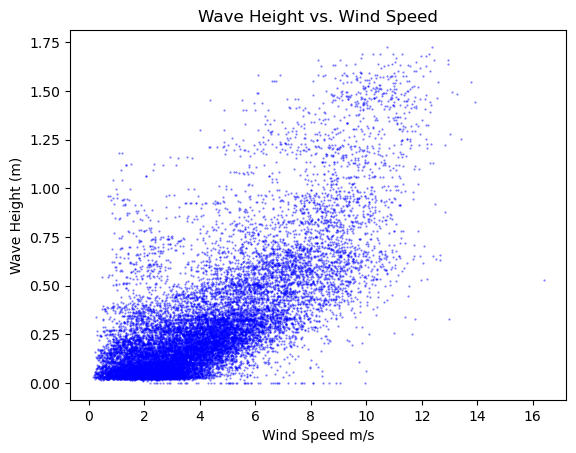

In [6]:
fig, ax = plt.subplots()
ax.scatter(df.loc[:, "wspd1 (m s-1)"], df.loc[:, "wvhgt (m)"], c='blue', s = 0.3, alpha = 0.5)
ax.set_xlabel('Wind Speed m/s')
ax.set_ylabel('Wave Height (m)')
ax.set_title('Wave Height vs. Wind Speed')

A scatterplot indicates a positive relationship between wave height and windspeed, but a relatively large amount of scatter is evident, especially at high windspeeds.  Other drivers are probably at work.  Let's visualize the influence of wind direction.

C:\Users\Daniel Sandborn\AppData\Local\Temp\ipykernel_19876\4057927884.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['N', 'NE', 'W', 'SW', 'S', 'SE', 'E', 'NE'])
C:\Users\Daniel Sandborn\AppData\Local\Temp\ipykernel_19876\4057927884.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', '', 'MEH', 'OKAY', 'GNARLY', 'RADICAL', 'SURF\'S UP!'])


Text(0.5, 1.0, 'Wave Height vs. Wind Direction (from)')

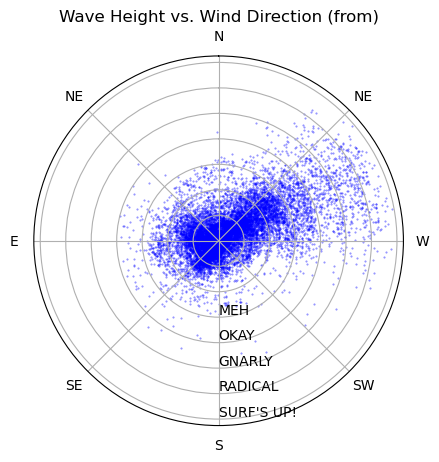

In [7]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(df.loc[:, "wdir1 (degree)"]/360*2*np.pi, df.loc[:, "wvhgt (m)"], c='blue', s = 0.2, alpha = 0.5)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_rlabel_position(180)
ax.set_xticklabels(['N', 'NE', 'W', 'SW', 'S', 'SE', 'E', 'NE'])
ax.set_yticklabels(['', '', 'MEH', 'OKAY', 'GNARLY', 'RADICAL', 'SURF\'S UP!'])
ax.set_title('Wave Height vs. Wind Direction (from)')

As expected, the largest waves are associated with winds from the northeast, which have the most fetch over Lake Superior.  We now have two probable driver variables, but how much of the variability in wave height do windspeed and wind direction determine?  Several different regression analyses could be deployed to quantify this as, for example, an R-squared value.  Keep in mind the potential complications of regression against a polar variable (direction); we'll give an example of this later.  

## Repeat Hydrography

Some categories of data aren't suitable for measurement by moorings.  Many chemical and biological parameters require analytical techniques that are challenging to automate or else require reagents and supplies that can't be supplied and disposed of in a remote location.  In these cases, research vessels are utilized to travel to stations where water or other samples are retrieved and analyzed by scientists.  Repetition of this process at regular intervals over years or decades constitutes a *repeat hydrography* campaign.  

The EPA Great Lakes National Program Office [(GLNPO)](https://www.epa.gov/aboutepa/about-great-lakes-national-program-office-glnpo) has produced such a dataset since the mid 1980s.  This set of chemical and biological measurements of discrete water samples at several dozen stations at various depths is among the most valuable long-term biogeochemical datasets available for the Great Lakes.  Its primary strength is its consistency: each years' data is comprable to all others thanks to standardized operating procedures and quality assurance/quality control (QA/QC).  

I've downloaded a summary of particulate matter analyses through an account on the [EPA GLENDA](https://exchangenetwork.net/data-exchange/glenda/) portal.  We'll analyze it below, beginning with a mapping exercise.

Text(0.5, 1.0, 'USEPA Great Lakes Water Quality Monitoring Project Sites')

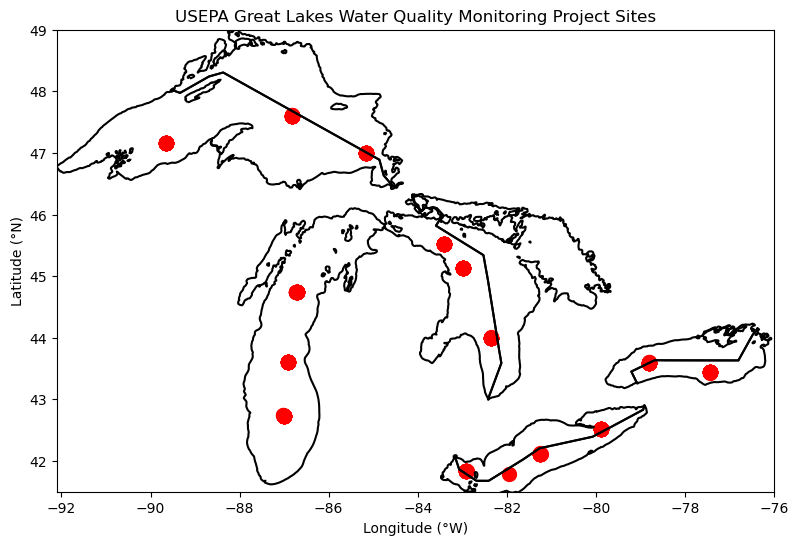

In [10]:
#grab shapefiles for mapping and convert them all to the same coordinate system
#these are available for just about any geographic object desired with a quick web search
michigan = gp.read_file('./Mapping/hydro_p_LakeMichigan.shp').to_crs("EPSG:4326") 
superior = gp.read_file('./Mapping/hydro_p_LakeSuperior.shp').to_crs("EPSG:4326")
erie = gp.read_file('./Mapping/hydro_p_LakeErie.shp').to_crs("EPSG:4326")
ontario = gp.read_file('./Mapping/hydro_p_LakeOntario.shp').to_crs("EPSG:4326")
huron = gp.read_file('./Mapping/hydro_p_LakeHuron.shp').to_crs("EPSG:4326")

df = pd.read_csv("GLWQMP_DoD.csv", parse_dates=['SAMPLING_DATE']) #grab the Great Lakes Water Quality Monitoring Project .csv datafile

fig, ax = plt.subplots(figsize=(10, 6)) #initialize matplotlib file
superior.boundary.plot(ax=ax, color='k') #plot the shape of each lake
michigan.boundary.plot(ax=ax, color='k')
huron.boundary.plot(ax=ax, color='k')
erie.boundary.plot(ax=ax, color='k')
ontario.boundary.plot(ax=ax, color='k')
ax.scatter(df.LONGITUDE, df.LATITUDE, c='r', s=100) #plot each sample on the map
ax.set_ylabel('Latitude (°N)')
ax.set_xlabel('Longitude (°W)')
ax.set_ylim([41.5, 49])
ax.set_xlim([-92.1, -76])
ax.set_title('USEPA Great Lakes Water Quality Monitoring Project Sites')

The great spatial scope of the EPA dataset is evident in this map of the Great Lakes.  Each station is represented as a cluster of observations.  Consider: can the biogeochemistry of such a large lake as Superior be comprehensively understood by measurements at merely three stations far from shore?  

These measurements are collected only twice annually, which limits their observational scope to some seasonal and interannual variability.  The comprehensive spatial scope, however, helps highlight interesting spatial variability that may be missed by fixed observational systems like buoys and coastal timeseries. Next we compare Particulate Organic Carbon concentrations among various stations with a box-and-whisker plot. How much variability is there among lakes?  Within lakes?  Why do some lakes contain more Particulate Organic Carbon than others? 

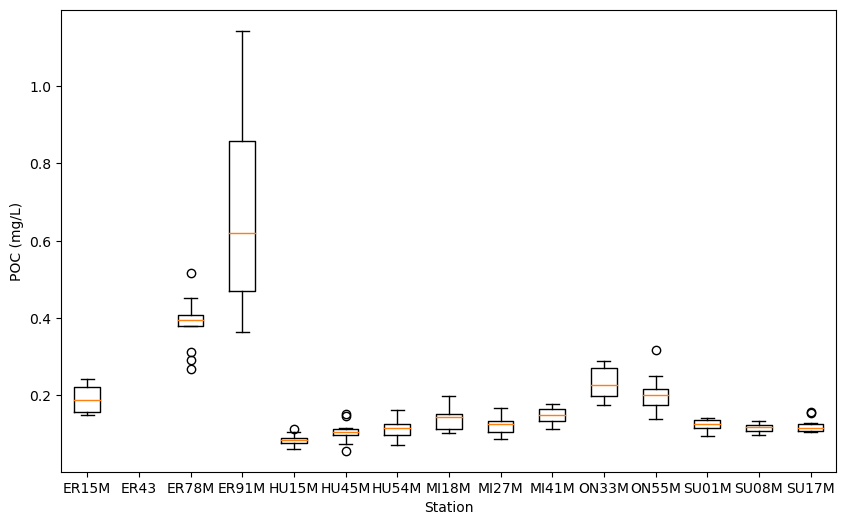

In [11]:
df_bwp = df.pivot_table(index='YEAR', columns='STATION',
                        values="Particulate Organic Carbon, mg/L") #separate out Particulate Organic Carbon values by station
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(df_bwp, labels=df_bwp.columns) #create a box-and-whisker plot for each station
ax.set_ylabel('POC (mg/L)')
ax.set_xlabel('Station')
plt.show()

We haven't examined how these values change over time.  For that, we'll use a timeseries plot.  Typically measurements are made in early spring (April-May) and late summer (July-August).  This explains the 'sharktooth' behavior in the timeseries, but it complicates interpretation of secular trends.  

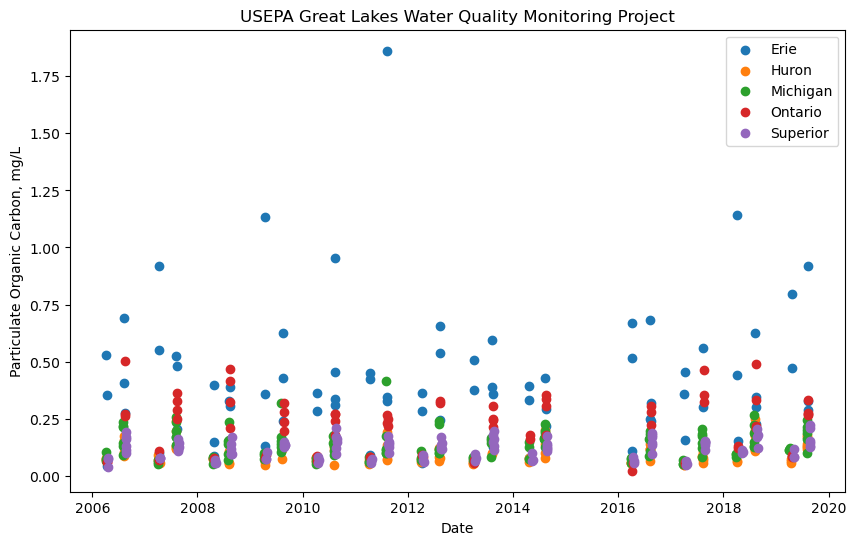

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
for i in df.LAKE.unique(): #for each lake:
    ax.scatter(df.loc[df.LAKE == i].SAMPLING_DATE, df.loc[df.LAKE == i] #make a scatterplot timeseries of POC over time
               ['Particulate Organic Carbon, mg/L'], label=i)
ax.set_ylabel('Particulate Organic Carbon, mg/L')
ax.set_xlabel('Date')
#ax.set_ylim([41.5, 49])
#ax.set_xlim([-92.1, -76])
ax.set_title('USEPA Great Lakes Water Quality Monitoring Project')
plt.legend()

There are many other variables in the provided EPA dataset.  Consider plotting them up and seeing if trends can be demonstrated.

## Research Vessel Underway Systems

Now we move to the third data source: underway instrumentation.  We've seen the utility of high-frequency, autonomous, but spatially-limited moorings.  We've demonstrated the flexibility and long-term potential of repeat hydrography transects, despite their high cost in labor an dmaterials.  Now we consider underway instrumentation as a strategy that combines strengths of both. 

These instruments operate on a vessel autonomously, measuring properties of water wherever the ship happens to travel.  These systems are installed on research vessels like UMD's Blue Heron, as well as "ships of opportunity" like ferries servicing Isle Royale and the Alaska Marine Highway.  Research vessels typically post their underway data to R2R [(Rolling Deck to Repository)](https://www.rvdata.us/).  I'm going to run a demonstration using data from the R/V Blue Heron, which recently installed a new instrument (SuperCO2, Sunburst Sensors) measuring CO<sub>2</sub> in water. 

This greenhouse gas has been accumulating in Earth's atmosphere due to fossil fuel emissions, though a significant fraction (>30%) of fossil carbon is sequestered in the ocean.  Our oceans limit the greenhouse potential of anthropogenic CO<sub>2</sub>, but there are side effects, including ocean acidification. CO<sub>2</sub> in water is influenced by temperature, pressue, salinity, photosynthesis, respiration, ice cover, and a host of other factors varying in space and time. This variability (which is enhanced in inland waters relative to the global ocean) necessitates observations that span space (like repeat hydrography transects) and time (like moorings).

Enter underway data.

![A screenshot of the Rolling Deck to Repository page for the R/V Blue Heron, with cruise tracks shown for the upper three Laurentian Great Lakes.](./Images/R2R.JPG "A screenshot of the Rolling Deck to Repository page for the R/V Blue Heron, with cruise tracks shown for the upper three Laurentian Great Lakes.")

The Blue Heron has visited the upper four Great Lakes since its CO<sub>2</sub> sensor was installed in 2019.  The resulting millions of measurements of CO<sub>2</sub> (along with water physical properties) cover Lake Superior most densely, so we'll restrict our attention there, focusing on a dataset I've assembled and sumarized from several hundred publically-available cruise files.

The surface water temperature in Lake Superior is plotted below.  Clearly, SST varies considerably both spatially (within-cruise), seasonally (along the x-axis) and interanually (denoted by color).  This comes as no surprise to astute weather observers: the winter of '21-'22 was particularly cold, so 2022 water temperatures were depressed until later into the summer.  

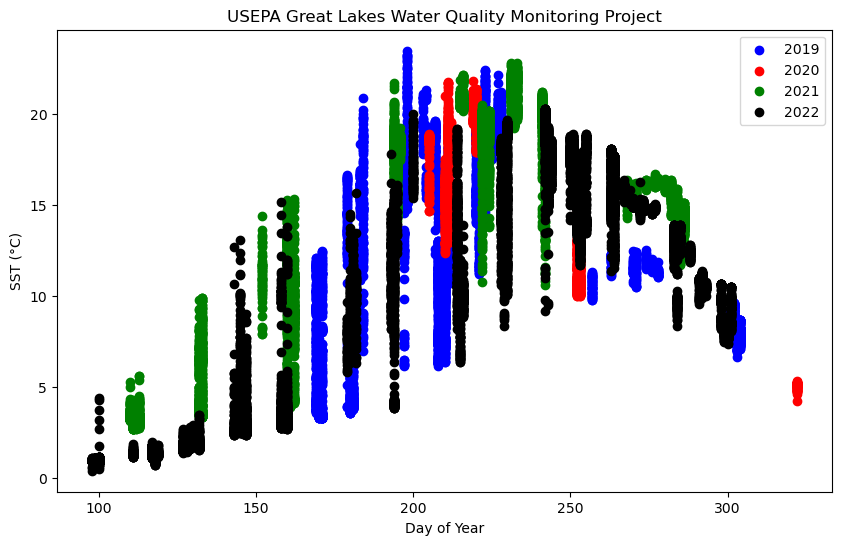

In [14]:
df = pd.read_csv('BH19202122_Processed_Grouped.csv')

fig, ax = plt.subplots(figsize=(10, 6))
#create a scatterplot of surface water temperatures over day of the year, colored by year
ax.scatter(df[df.Year == 2019].DOY, 
           df[df.Year == 2019].Temp, 
           c='b', label='2019')
ax.scatter(df[df.Year == 2020].DOY,
           df[df.Year == 2020].Temp, 
           c='r', label='2020')
ax.scatter(df[df.Year == 2021].DOY,
           df[df.Year == 2021].Temp, 
           c='g', label='2021')
ax.scatter(df[df.Year == 2022].DOY,
           df[df.Year == 2022].Temp, 
           c='k', label='2022')
ax.set_ylabel('SST (°C)')
ax.set_xlabel('Day of Year')
ax.set_title('USEPA Great Lakes Water Quality Monitoring Project')
plt.legend()

This affects more than just surfing and shipping conditions (each of which, of course, are highly important in Duluth!)  Cold water absorbs more CO<sub>2</sub> than warm water.  It's reasonable to hypothesize that there could be differences in how Lake Superior 'breathes' CO<sub>2</sub> among years.

A plot of CO<sub>2</sub> measurements (normalized by area to avoid biasing the dataset if the vessel idles in place) displays a sinusoidal shape, at times containing more CO<sub>2</sub> than the air (as if exhaling) or else containing less than the air (as if inhaling).  

Now we separate the sinusoidal regression of 2022 from the others.  It appears to be phase shifted later in the year, in line with our observation of a later spring in 2022! The amplitude of the 2022 curve is also smaller (shallow breaths?). 

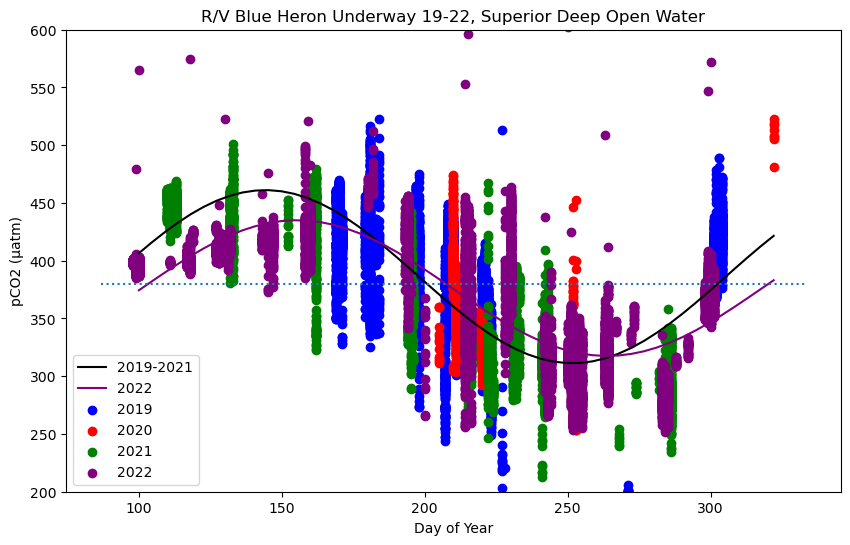

In [16]:
def test_func(x, a, b, c, d): #define a generalized sinusoidal equation
    return a * np.sin(b * (x-c)/365*2*np.pi)+d

def abline(slope, intercept, **kwargs): #this helps us plot lines quickly
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, ':', **kwargs)
    
# Open Water
x_data = df.loc[df['Depthcode'] == 'Deep'].dropna(subset=['pCO2'])['DOY'] #pick out the independent variable
y_data = df.loc[df['Depthcode'] == 'Deep'].dropna(subset=['pCO2'])['pCO2'] #pick out the dependent variable
#regress the dependent variable against the independent variable according to the sinusoidal function
params, params_covariance = optimize.curve_fit(test_func, x_data, y_data, p0=[-200, 1, 1, 400]) 

#do the same thing for subsets of the data by year: before 2022 and 2022 only
x_data22 = df[df.Year == 2022].loc[df['Depthcode'] == 'Deep'].dropna(subset=['pCO2'])['DOY']
y_data22 = df[df.Year == 2022].loc[df['Depthcode'] == 'Deep'].dropna(subset=['pCO2'])['pCO2']
params22, params_covariance22 = optimize.curve_fit(test_func, x_data22, y_data22, p0=[-200, 1, 1, 400])

x_data1921 = df[df.Year < 2022].loc[df['Depthcode'] == 'Deep'].dropna(subset=['pCO2'])['DOY']
y_data1921 = df[df.Year < 2022].loc[df['Depthcode'] == 'Deep'].dropna(subset=['pCO2'])['pCO2']
params1921, params_covariance1921 = optimize.curve_fit(test_func, x_data1921, y_data1921, p0=[-200, 1, 1, 400])

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.linspace(100, 322),
        test_func(np.linspace(100, 322), 
        params1921[0], params1921[1], params1921[2], params1921[3]), 
        c='k', label='2019-2021')
ax.plot(np.linspace(100, 322),
        test_func(np.linspace(100, 322), 
        params22[0], params22[1], params22[2], params22[3]), 
        c='purple', label='2022')
ax.scatter(df[df.Year == 2019].loc[df['Depthcode'] == 'Deep'].DOY,
           df[df.Year == 2019].loc[df['Depthcode'] == 'Deep'].pCO2, 
           c='b', label='2019')
ax.scatter(df[df.Year == 2020].loc[df['Depthcode'] == 'Deep'].DOY,
           df[df.Year == 2020].loc[df['Depthcode'] == 'Deep'].pCO2, 
           c='r', label='2020')
ax.scatter(df[df.Year == 2021].loc[df['Depthcode'] == 'Deep'].DOY,
           df[df.Year == 2021].loc[df['Depthcode'] == 'Deep'].pCO2, 
           c='g', label='2021')
ax.scatter(df[df.Year == 2022].loc[df['Depthcode'] == 'Deep'].DOY,
           df[df.Year == 2022].loc[df['Depthcode'] == 'Deep'].pCO2, 
           c='purple', label='2022')
abline(0, 380)
ax.set_ylabel('pCO2 (μatm)')
ax.set_xlabel('Day of Year')
ax.set_ylim([200, 600])
#ax.set_xlim([-92.1, -76])
ax.set_title('R/V Blue Heron Underway 19-22, Superior Deep Open Water')
plt.legend()

## Wrap-up

I hope this demo has been interesting and useful!  While far from a comprehensive treatment of data access and analysis techniques, the examples provided here have the potential to inspire readers, advance data science skills, and increase engagement with the science of one of humanity's most valuable resources: water!

Please contact me with any questions.  I'd love to hear comments, suggestions, project ideas, etc. *sandb425@umn.edu*

## References
[^1]: Bushinsky, S. M., Y. Takeshita, and N. L. Williams. 2019. Observing Changes in Ocean Carbonate Chemistry: Our Autonomous Future. Curr Clim Change Rep 5: 207–220. doi:10.1007/s40641-019-00129-8
[^2]: "The Great Lakes". USEPA. Accessed December 20 2022. [www.epa.gov/greatlakes](https://www.epa.gov/greatlakes)
[^3]: Austin, J., and S. Colman. 2008. A century of temperature variability in Lake Superior. Limnol. Oceanogr. 53: 2724–2730. doi:10.4319/lo.2008.53.6.2724
[^4]: Chapra, S. C., A. Dove, and G. J. Warren. 2012. Long-term trends of Great Lakes major ion chemistry. Journal of Great Lakes Research 38: 550–560. doi:10.1016/j.jglr.2012.06.010
[^5]: Sterner, R. W., K. L. Reinl, B. M. Lafrancois, S. Brovold, and T. R. Miller. 2020. A first assessment of cyanobacterial blooms in oligotrophic Lake Superior. Limnol Oceanogr 65: 2984–2998. doi:10.1002/lno.11569
[^6]: Sandborn, D. E., and E. C. Minor. 2022. CO~2~ Acidification in Lake Superior: Developing a Chemical Forecast. Poster Presentation.  Joint Aquatic Sciences Meeting, Grand Rapids, MI, USA.
[^7]: Phillips, J., G. McKinley, V. Bennington, H. Bootsma, D. Pilcher, R. Sterner, and N. Urban. 2015. The Potential for CO~2~-Induced Acidification in Freshwater: A Great Lakes Case Study. oceanog 25: 136–145. doi:10.5670/oceanog.2015.37
[^8]: Ozersky, T., A. J. Bramburger, A. K. Elgin, and others. 2021. The Changing Face of Winter: Lessons and Questions From the Laurentian Great Lakes. J Geophys Res Biogeosci 126. doi:10.1029/2021JG006247